# Ikeda for many ships with quadratic contributions
The method developed in: ([01.03_ikeda_many_dev](06_ikeda/01.03_ikeda_many_dev.ipynb)) will now be attempted for many ships.
Instead of just calculating ikeda for one roll amplitude, it will now be calculated for 2 amplitudes to derive the quadratic part $B_2$ 


In [3]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [5]:
from pyscores2.indata import Indata
from pyscores2.runScores2 import Calculation
from pyscores2.output import OutputFile
from pyscores2 import TDPError
import pyscores2
from rolldecayestimators.ikeda import Ikeda, IkedaR
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import subprocess
from rolldecayestimators import measure

In [6]:
df_all_sections_id = pd.read_csv('../data/external/all_sections.csv', sep=';')
df_all_sections_id.head()

,b,area,t,x,SHIP,loading_condition_id
0,0.00,0.0,0.0,0.00,68,NaN
1,26.86,19.5,6.6,8.61,68,NaN
2,28.17,54.7,6.6,17.22,68,NaN
3,28.40,96.0,6.6,25.83,68,NaN
4,28.40,129.4,6.6,34.44,68,NaN


In [7]:
section_groups=df_all_sections_id.groupby(by='loading_condition_id')

In [8]:
loading_condition_ids = df_all_sections_id['loading_condition_id'].unique()
mask=pd.notnull(loading_condition_ids)
loading_condition_ids=loading_condition_ids[mask]

In [9]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.99, 
                             exclude_table_name='rolldecay_exclude')

In [10]:
mask=df_rolldecay['loading_condition_id'].isin(loading_condition_ids)
df=df_rolldecay.loc[mask].copy()

In [11]:
df['BKB'].fillna(0, inplace=True)

In [12]:
def add_cScores(sections):
    sections=sections.copy()
    sections['cScores']=sections['area']/(sections['b']*sections['t'])
    mask=sections['cScores']>1
    sections.loc[mask,'cScores']=1
    return sections

def cut_sections(sections, draught):
    sections=sections.copy()
    mask = sections['t']>draught
    sections.loc[mask,'t']=draught
    sections.loc[mask,'area']-=draught*sections['b'].max()  # Assuming rectangular shape
    return sections

def remove_duplicate_sections(sections):
    sections=sections.copy()
    mask=~sections['x'].duplicated()
    sections=sections.loc[mask]
    assert sections['x'].is_unique
    return sections

def too_small_sections(sections):
    sections=sections.copy()
    small = 0.1
    mask=sections['b']==0
    sections.loc[mask,'b']=small
    mask=sections['t']==0
    sections.loc[mask,'t']=small
    mask=sections['area']==0
    sections.loc[mask,'area']=small
    return sections

In [13]:
from scipy.integrate import simps
def calculate_lcb(x, area, **kwargs):
    """
    Calculate lcb from AP
    """
    return simps(y=area*x,x=x)/np.trapz(y=area,x=x)

def calculate_dispacement(x, area, **kwargs):
    """
    Calculate displacement
    """
    return np.trapz(y=area,x=x)

In [14]:
class DraughtError(ValueError): pass

def define_indata(row, sections, rho=1000,  g=9.81):
    
    indata = Indata()
    
    draught=(row.TA+row.TF)/2
    indata.draught=draught
    if draught<=sections['t'].max():
        sections = cut_sections(sections, draught)
    else:
        raise DraughtError('Draught is too large for sections')
    
    sections=add_cScores(sections)
    
    indata.cScores=np.array(sections['cScores'])
    indata.ts=np.array(sections['t'])
    indata.bs=np.array(sections['b'])
    indata.zbars=np.zeros_like(sections['b'])  # Guessing...
        
    beam=sections['b'].max()
    indata.lpp=sections['x'].max()-sections['x'].min()
    #indata.displacement=row.Volume
    indata.displacement=calculate_dispacement(**sections)
    
    indata.g=g
    indata.kxx=row.KXX
    indata.kyy=row.lpp*0.4
    lcb=calculate_lcb(x=sections['x'], area=sections['area'])
    indata.lcb=lcb-row.lpp/2
    indata.lpp=row.lpp
    indata.projectName='loading_condition_id_%i' % row.loading_condition_id
    
    indata.rho=rho
    indata.zcg=row.kg-draught
    #indata.waveFrequenciesMin=0.2
    #indata.waveFrequenciesMax=0.5
    #indata.waveFrequenciesIncrement=0.006
    w=row.omega0/np.sqrt(row.scale_factor)
    indata.waveFrequenciesMin=w*0.5
    indata.waveFrequenciesMax=w*2.0
    N=40
    indata.waveFrequenciesIncrement=(indata.waveFrequenciesMax-indata.waveFrequenciesMin)/N
    indata.runOptions["IE"].set_value(1)
    
    return indata,sections

In [25]:
def create_ikeda(row, indata, output_file, fi_a):

    w = row.omega0
    scale_factor=row.scale_factor
    V = row.ship_speed*1.852/3.6/np.sqrt(scale_factor)
    R = 0.01*row.beam/scale_factor
    lBK=row.BKL/scale_factor
    bBK=row.BKB/scale_factor
    kg = row.kg/scale_factor
    
    ikeda = Ikeda.load_scoresII(V=V, w=w, fi_a=fi_a, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=lBK, BKB=bBK, kg=kg)
        
    return ikeda

In [16]:
def calculate_ikeda(ikeda):

    output = pd.DataFrame()
    output['B_44_hat']   = ikeda.calculate_B44()
    output['B_W0_hat']   = float(ikeda.calculate_B_W0())
    output['B_W_hat']    = float(ikeda.calculate_B_W())
    output['B_F_hat']    = ikeda.calculate_B_F()
    output['B_E_hat']    = ikeda.calculate_B_E()
    output['B_BK_hat']   = ikeda.calculate_B_BK()
    output['B_L_hat']    = float(ikeda.calculate_B_L())
    output['Bw_div_Bw0'] = float(ikeda.calculate_Bw_div_Bw0())
    return output

In [19]:
def get_B_1_B2(s1,s2,fi_as:np.ndarray):    
    
    # Derive linear and quadratic part for all components:
    
    if isinstance(s1,pd.Series):
        result=pd.Series(name=row.name)
        columns = s1.index
    elif isinstance(s1,pd.DataFrame):
        result=pd.DataFrame()
        columns = s1.columns
    else:
        raise ValueError('s1 must be pd.Series or pd.DataFrame')
    
    x = fi_as*8*row.omega0/(3 * np.pi)
    B_2 = (s2 - s1) / (x[1] - x[0])
    B_1 = s1 - B_2 * x[0]
    
    # Save all of the component as one linear term: _1 and a quadratic term: _2
    
    
    for key in columns:
        new_name_1 = '%s_1' % key
        result[new_name_1] = s1[key]

        new_name_2 = '%s_2' % key
        result[new_name_2] = s2[key]
        
    return result

In [27]:
results = pd.DataFrame()
fi_as = np.deg2rad([1,10])
for run_name, row in df.iterrows():
    loading_condition_id=row['loading_condition_id']
    sections = section_groups.get_group(loading_condition_id)
    sections=remove_duplicate_sections(sections)
    sections=too_small_sections(sections)
    
    try:
        indata,sections_ = define_indata(row, sections)
    except DraughtError as e:
        print('Draught is too large for sections, this loading condition is skipped.')
        continue

        
    save_name='%s.in' % row.loading_condition_id
    save_path=os.path.join('scores',save_name)
    indata.save(save_path)
    
    calculation = Calculation(outDataDirectory='scores/result')
    
    # Run scoresII:
    try:
        calculation.run(indata=indata, b_div_t_max=None, timeout=1.0)
    except TDPError:
        print('Dissregarding the TDPError')
        continue
    except pyscores2.LcgError as e:
        print('Disregarded')
        print(e)
        continue
    except subprocess.TimeoutExpired:
        print('Disregarded, scoresII got stuck...')
        continue
        
    output_file = OutputFile(filePath=calculation.outDataPath)
    
    
    ikeda = create_ikeda(row=row, indata=indata, output_file=output_file, fi_a=fi_as)
    result_datas = ikeda.calculate()
    #result_datas = calculate_ikeda(ikeda)  # DataFrame with two roll amplitudes
    
    # Derive linear and quadratic part for all components:
    s1=result_datas.iloc[0]
    s2=result_datas.iloc[1]
    result = get_B_1_B2(s1=s1, s2=s2, fi_as=fi_as)
    
    
    results=results.append(result)
    

Running Scores2 for loading_condition_id_107


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_14


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_34


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_14


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_14


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_34


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_34


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_34


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_89
Disregarded, scoresII got stuck...
Running Scores2 for loading_condition_id_119


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_89
Disregarded, scoresII got stuck...
Running Scores2 for loading_condition_id_10


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_119


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_99
Disregarded, scoresII got stuck...
Running Scores2 for loading_condition_id_10


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_10


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_6


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_3
Dissregarding the TDPError
Running Scores2 for loading_condition_id_3
Dissregarding the TDPError
Running Scores2 for loading_condition_id_6


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_6


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_37


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_15


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_20


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_106


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_15


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_15


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_106


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_106


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Draught is too large for sections, this loading condition is skipped.
Running Scores2 for loading_condition_id_100


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Draught is too large for sections, this loading condition is skipped.
Running Scores2 for loading_condition_id_8


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_8


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Draught is too large for sections, this loading condition is skipped.
Draught is too large for sections, this loading condition is skipped.
Running Scores2 for loading_condition_id_118
Disregarded, scoresII got stuck...
Running Scores2 for loading_condition_id_13


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_1


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_13


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_13


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_4


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_4


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_49
Disregarded
<class 'pyscores2.LcgError'>: The calculated longitudinal centre of bouyancy differ from the nomonal value ((LCB-LCG)/L max 0.5%) Calculated LCB = 4.271000 m (FWD. OF MIDSHIPS)
Running Scores2 for loading_condition_id_22


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_7


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_7


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_7


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_107


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_78


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_32


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silen

Running Scores2 for loading_condition_id_78


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_78


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_78


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_107


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_21


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_21


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_19


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_107


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_79


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_79


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Running Scores2 for loading_condition_id_79


c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [28]:
results['id']=results.index

In [29]:
results

,B_44_hat_1,B_44_hat_2,B_BK_hat_1,B_BK_hat_2,B_E_hat_1,B_E_hat_2,B_F_hat_1,B_F_hat_2,B_L_hat_1,B_L_hat_2,B_W0_hat_1,B_W0_hat_2,B_W_hat_1,B_W_hat_2,Bw_div_Bw0_1,Bw_div_Bw0_2,id
14848,0.004185,0.008983,0.000490,0.005110,0.000005,0.000053,0.000591,0.000722,0.002860,0.002860,0.000034,0.000034,0.000238,0.000238,6.967885,6.967885,14848
2570,0.001133,0.005699,0.000393,0.004544,0.000035,0.000352,0.000426,0.000525,0.000018,0.000018,0.000261,0.000261,0.000261,0.000261,1.000605,1.000605,2570
4620,0.000682,0.001005,0.000000,0.000000,0.000027,0.000266,0.000347,0.000430,0.000000,0.000000,0.000308,0.000308,0.000308,0.000308,1.000436,1.000436,4620
2573,0.005408,0.009717,0.000407,0.004519,0.000008,0.000078,0.000553,0.000680,0.002474,0.002474,0.000259,0.000259,0.001966,0.001966,7.594869,7.594869,2573
2574,0.006185,0.010625,0.000428,0.004681,0.000005,0.000050,0.000608,0.000750,0.003446,0.003446,0.000266,0.000266,0.001699,0.001699,6.376932,6.376932,2574
4629,0.008334,0.008492,0.000000,0.000000,0.000001,0.000012,0.000611,0.000758,0.005772,0.005772,0.000311,0.000311,0.001950,0.001950,6.264634,6.264634,4629
4630,0.006317,0.006465,0.000000,0.000000,0.000002,0.000022,0.000535,0.000663,0.004123,0.004123,0.000306,0.000306,0.001657,0.001657,5.418093,5.418093,4630
4631,0.002898,0.003068,0.000000,0.000000,0.000007,0.000071,0.000441,0.000547,0.002061,0.002061,0.000308,0.000308,0.000388,0.000388,1.259106,1.259106,4631
15923,0.001965,0.006245,0.000327,0.003988,0.000059,0.000586,0.000423,0.000515,0.000000,0.000000,0.001156,0.001156,0.001156,0.001156,1.000292,1.000292,15923
2104,0.000956,0.004896,0.000344,0.003948,0.000027,0.000267,0.000401,0.000497,0.000000,0.000000,0.000184,0.000184,0.000184,0.000184,1.000510,1.000510,2104


In [30]:
results.head()

,B_44_hat_1,B_44_hat_2,B_BK_hat_1,B_BK_hat_2,B_E_hat_1,B_E_hat_2,B_F_hat_1,B_F_hat_2,B_L_hat_1,B_L_hat_2,B_W0_hat_1,B_W0_hat_2,B_W_hat_1,B_W_hat_2,Bw_div_Bw0_1,Bw_div_Bw0_2,id
14848,0.004185,0.008983,0.000490,0.005110,0.000005,0.000053,0.000591,0.000722,0.002860,0.002860,0.000034,0.000034,0.000238,0.000238,6.967885,6.967885,14848
2570,0.001133,0.005699,0.000393,0.004544,0.000035,0.000352,0.000426,0.000525,0.000018,0.000018,0.000261,0.000261,0.000261,0.000261,1.000605,1.000605,2570
4620,0.000682,0.001005,0.000000,0.000000,0.000027,0.000266,0.000347,0.000430,0.000000,0.000000,0.000308,0.000308,0.000308,0.000308,1.000436,1.000436,4620
2573,0.005408,0.009717,0.000407,0.004519,0.000008,0.000078,0.000553,0.000680,0.002474,0.002474,0.000259,0.000259,0.001966,0.001966,7.594869,7.594869,2573
2574,0.006185,0.010625,0.000428,0.004681,0.000005,0.000050,0.000608,0.000750,0.003446,0.003446,0.000266,0.000266,0.001699,0.001699,6.376932,6.376932,2574


In [31]:
df.head()

,model_number,loading_condition_id,ship_speed,B_1A,B_2A,C_1A,B_1,B_2,C_1,A_44,omega0,omega0_fft,score,phi_start,phi_stop,id,project_number,series_number,run_number,test_number,ship_name,ascii_name,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,project_path,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id
run_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14848,3541-A,107,13.0,0.088786,0.442492,6.175780,6.821454,33.996705,474.485974,76.830134,2.485112,2.488141,0.999477,-0.138416,0.006405,14848,20136522,1,32,1,3541-A,20136522-ser001-k032-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20136522-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2014-12-29,roll decay,MDL,None,None,Kursstyrning,20136522_Hudong-Zhonghua 170k class LNGC,S:\2013\20136522-Hudong-Zhonghua-170k-class-LNG,-4.190,18.38,3.80,0.847,11.50,11.50,46.97,15.5,65.32,3.36,0.7669,116472.0,0.9899,8.50,55.0000,284.00,46.97,5.1,-7.665,1.0,8.4,19.8,9.2,130.0,0.991,0.00,None,None,20000.0,1.0,NaN,92.13,0.43,3.0,8.3,28.0,2.32,-123.0,67.8,49.40,0.0,0.0,2.0,1.0,-142.00,None,7.7,58.0,290.00,4.0
2570,3239-A,14,0.1,0.017279,0.525094,5.870454,1.869850,56.822711,635.267667,108.214410,2.422902,2.425310,0.999079,-0.151823,0.015199,2570,20074477,1,27,1,3239-A,20074477-ser001-k027-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20074477-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2007-11-20,roll decay,MDL,None,None,Kursstyrning,20074477,\\sspa.local\gbg\ProjektArkiv\2007\20074477,-0.953,17.40,3.89,0.843,11.50,11.50,45.80,15.1,66.20,2.44,0.7566,114188.0,0.9900,11.20,51.1765,288.00,45.80,49.0,1.000,0.0,0.0,19.5,11.4,120.0,0.800,16.66,None,None,NaN,1.0,NaN,90.55,0.40,1.0,8.7,24.0,2.32,-127.0,78.5,81.34,0.0,0.0,1.0,1.0,-144.00,None,7.1,8.7,300.00,4.0
4620,Aker,34,0.0,0.011280,0.102312,4.532723,1.524651,13.829206,612.671657,135.166363,2.129019,2.130000,0.999027,-0.155755,-0.001109,4620,20095111,1,7,1,Aker,20095111-ser001-k007-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20095111-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2009-11-02,roll decay,MDL,None,None,Kursstyrning,20095111,\\sspa.local\gbg\ProjektArkiv\2009\20095111,-1.390,10.06,1.86,NaN,8.53,8.53,24.38,9.2,27.60,2.85,NaN,14648.0,0.9940,4.34,25.7000,92.66,24.38,0.0,0.000,0.0,5.4,16.0,5.5,52.0,1.089,0.00,None,None,16946.0,1.0,NaN,0.00,0.00,3.0,4.6,18.5,2.32,-40.5,150.0,15.50,0.0,0.0,2.0,1.0,-46.33,None,5.9,0.0,109.93,8.0
2573,3239-A,14,14.0,0.092735,0.593809,5.774783,10.201494,65.323279,635.267667,110.007200,2.403078,2.400177,0.997486,0.146696,0.012351,2573,20074477,1,30,1,3239-A,20074477-ser001-k030-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20074477-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2007-11-20,roll decay,MDL,None,None,Kursstyrning,20074477,\\sspa.local\gbg\ProjektArkiv\2007\20074477,-0.953,17.40,3.89,0.843,11.50,11.50,45.80,15.1,66.20,2.44,0.7566,114188.0,0.9900,11.20,51.1765,288.00,45.80,49.0,1.000,0.0,0.0,19.5,11.4,120.0,0.800,16.66,None,None,NaN,1.0,NaN,90.55,0.40,1.0,8.7,24.0,2.32,-127.0,78.5,81.34,0.0,0.0,1.0,1.0,-144.00,None,7.1,8.7,300.00,4.0
2574,3239-A,14,19.5,0.223103,0.396531,6.181753,22.927161,40.749456,635.267667,102.764975,2.486313,2.494425,0.997824,0.132958,0.005539,2574,20074477,1,31,1,3239-A,20074477-ser001-k031-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20074477-ser001-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2007-11-20,roll decay,MDL,None,None,Kursstyrning,20074477,\\sspa.local\gbg\ProjektArkiv\2007\20074477,-0.953,17.40,3.89,0.843,11.50,11.50,45.80,15.1,66.20,2.44,0.7566,114188.0,0.9900

## Make comparison with model tests

In [32]:
df2 = df.copy()
scale_factor = df2['scale_factor']
df2['Volume']/=(scale_factor**3)
df2['Disp']=df2['Volume']
df2['beam']/=scale_factor
df2['lpp']/=scale_factor
df2['kg']/=scale_factor
df2['BKB']/=scale_factor
df2['BKL']/=scale_factor




In [33]:
df['Disp']=df2['Volume']
results['Disp']=df2.loc[results.index,'Disp']
results['omega0']=df2.loc[results.index,'omega0']

#df_compare = measure.linearized_matrix(df_rolldecay=df2, df_ikeda=results, do_hatify=False)
#mask=df_compare['B_e_hat_ikeda'].notnull()
#df_compare=df_compare.loc[mask].copy()

In [34]:
def linearize_model_tests(df_rolldecay, phi_as = np.deg2rad(np.linspace(1,10,10)), g=9.81, rho=1000):

    df = pd.DataFrame()
    
    for phi_a in phi_as:
        df_ = measure.linearize_model_test(phi_a=phi_a, df_rolldecay=df_rolldecay, g=g, rho=rho)
        df_['phi_a']=phi_a
        df =df.append(df_, ignore_index=True)
        
    return df

def linearize_ikedas(df_ikeda, phi_as = np.deg2rad(np.linspace(1,10,10)), g=9.81, rho=1000,
                     components = ['B_44_hat', 'B_F_hat', 'B_W_hat', 'B_E_hat', 'B_BK_hat', 'B_L_hat']):

    df = pd.DataFrame()
    
    
    for phi_a in phi_as:
        df_ = measure.linearize_si(phi_a=phi_a, df_ikeda=df_ikeda, do_hatify=False, components=components)
        df_['phi_a']=phi_a
        df =df.append(df_, ignore_index=True)
        
    return df

In [35]:
df_rolldecays=linearize_model_tests(df_rolldecay=df2)
df_ikedas=linearize_ikedas(df_ikeda=results)
df_ikedas.dropna(subset=['B_e_hat'], inplace=True)

In [36]:
df_compare = pd.merge(left=df_rolldecays, right=df_ikedas, how='inner', left_on=('id','phi_a'), right_on=('id','phi_a'), suffixes=('','_ikeda'))

<AxesSubplot:xlabel='B_e_hat'>

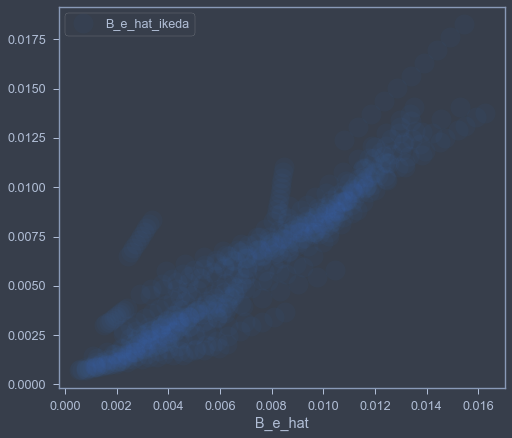

In [37]:
fig,ax=plt.subplots()
df_compare.plot(x='B_e_hat', y='B_e_hat_ikeda', ax=ax, style='o', alpha=0.05, ms=20, markeredgewidth=0)